# Numerics Lab Astrophysics SS2023:

## Focus Project: N-Body Problem with Runge-Kutta 4th Order Method

For the focus project the numpy and matplotlib modules were imported. Moreover, the mplot3d visualization tool from mpl_toolkits and the coconv module was imported, which converts orbital elements in heliocentric coordinates to barycentric coordinates and viceversa. This code was made available by Maximilian Zimmerman.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from coconv import kepToCart, cartToKep

## N-Body Problem with RK4
For the focus project the Runge-Kutta 4th order method is implemented and used to calculate the evolution of the orbits of multiple planets around its star, as well as many asteroids. The Runge-Kutta 4th order method is arguably the most commonly used integration method for ODE's due to its high accuracy and simplicity. This method requires storing three intermediate stage values to get four functions. A certain superposition of the four functions is then calculated to get the next value of the calculation. The error of the scheme is of the order $\mathcal{O}(h^{5})$, which makes it a 4th-order method, with h being the step-size. The price for this high accuracy is that it requires four evaluations of the right-hand side function of the ODE's per time step. However, the stability is also improved compared to the Euler method. For highly chaotic orbits even the RK4 method is not stable enough to trace these kind of orbits.

To understand what equations are necessary to integrate the N-body problem with the RK4 method, the according N-body problem is considered. The motion of N point masses in their mutual gravitational field is the classical N-body problem. Each particle i with mass $m_{i}$ has the location $r_{i}$ and the velocity $v_{i}$ at time t. The Hamiltonian of this system reads: $$H=\sum_{i=1}^{N}\frac{p_{i}}{2m_{i}}-\sum_{i=1}^{N}\sum_{j=i+1}^{N}\frac{Gm_{i}m_{j}}{|q_{i}-q_{j}|}$$ with the gravitational constant G and the canonical coordinates momentum $p_{i}=m_{i}v_{i}$ and location $q_{i}=r_{i}$ for all $i=1…N$ point masses. The Hamiltonian Equations yield the equations of motion for particle i: $$\dot{q}_{i}=\frac{\partial H}{\partial p_{i}} \Longrightarrow \frac{\text{d}r_{i}}{\text{d}t}=v_{i}$$ $$\dot{p}_{i}=-\frac{\partial H}{\partial q_{i}} \Longrightarrow \frac{\text{d}v_{i}}{\text{d}t}=a_{i}$$ with the acceleration: $$a_{i}(t)=\sum_{j\neq i}^{N}Gm_{j}\frac{r_{ij}}{|r_{ij}|^{3}}$$ where $r_{ij}$ is defined as: $r_{ij}=r_{j}(t)-r_{i}(t)$.

In order to calculate the trajectories of the point masses one needs to solve the corresponding equations of motion for each particle i, which is the system of ODE's given above with appropriate initial locations and velocities. In general, this is only possible via numerical methods. Thus, the particle distribution can only be determined at discrete time values. Starting from the current point in time $t=t_{n}$ the location and velocity at a later point in time $t_{n+1}=t_{n}+\Delta t$ are calculated. Then, $t_{n+1}$ takes the role of the current time instance $t_{n}$ and the algorithm continues to progress the solution until the desired end time is reached.

For this project a N-body simulation of the eight planets of the solar system is done, as well as a simulation of the first five planets with the inclusion of the asteroid belt with 100 asteroids.

The first thing to calculate are the accelerations of the objects involved in the simulation. After defining the gaussian gravitational constant one basically codes the acceleration equation from above.

In [2]:
def calculate_acceleration(positions, masses):
    """
    This function calculates the accelerations of the objects involved in the N-body problem
    
    Args:
    positions (numpy.array) -- positions of the objects
    masses (numpy.array) -- masses of the objects
    
    Returns:
    acceleration (numpy.array) -- accelerations of the object
    """
    k = 0.01720209895
    G = k * k
    acceleration = np.zeros((len(positions), 3))
    for i in range(len(positions)):
        for j in range(len(positions)):
            if i != j and masses[j] != 0:  # if not massless
                r = positions[i] - positions[j]
                acceleration[i] -= G * masses[j] * r/np.linalg.norm(r)**3
                
    return acceleration

The next step is to calculate the derivative quantities of the objects involved, which are the left hand sides of the equations of motion. For the acceleration the just defined function is applied. The velocities and accelerations are then concatenated into a single array.

In [3]:
def calculate_derivatives(state, masses):
    """
    This function calculates the derivative quantities of the objects involved in the N-body problem
    
    Args:
    state (numpy.array) -- states of the objects (positions, velocities)
    masses (numpy.array) -- masses of the objects
    
    Returns:
    (numpy.array) -- derivative quantities of the object
    """
    num_bodies = len(masses)
    positions = state[:num_bodies]
    velocities = state[num_bodies:]
    accelerations = calculate_acceleration(positions, masses) 
    return np.concatenate([velocities, accelerations])

Since the objects are not initially in barycenter position, one needs to define a function that does it. The total mass and the corresponding barycenter has to be calculated and then the positions get corrected by the barycenter position. The same is done for the velocities.

In [4]:
def move_to_barycenter(positions, velocities, masses):
    """
    This function corrects the positions of the objects involved in the N-body problem to barycenter positions
    
    Args:
    positions (numpy.array) -- positions of the objects
    velocities (numpy.array) -- velocities of the objects
    masses (numpy.array) -- masses of the objects
    
    Returns:
    positions (numpy.array) -- barycenter corrected positions of the objects
    velocities (numpy.array) -- barycenter corrected velocities of the objects
    """
    total_mass = np.sum(masses)
    barycenter = np.sum(positions * masses[:, np.newaxis], axis = 0)/total_mass
    positions -= barycenter
    velocities -= np.sum(velocities * masses[:, np.newaxis], axis = 0)/total_mass
    return positions, velocities

Now one defines the RK4 method to calculate the next time-step for the trajectories of the planet in the N-body system. Firstly, the initial positions and initial velocities are defined, which are passed as inputs. Then the number of steps define the length of integration, where the positions and velocities are moved to the barycenter and then the RK4 algorithm calculates the derivatives of them. The positions and velocities are saved for every time-step calculation.

In [5]:
def rk4_n_body(time_step, num_steps, initial_positions, initial_velocities, masses):
    """
    This function calculates the Runge-Kutta 4th order scheme of the objects involved in the N-body problem
    
    Args:
    time_step (float) -- time-step of the integration
    num_steps (int) -- number of steps of the integration
    initial_positions (numpy.array) -- initial positions of the objects
    initial_velocities (numpy.array) -- initial velocities of the objects
    masses (numpy.array) -- masses of the objects
    
    Returns:
    positions (numpy.array) -- positions of the objects after the integration
    velocities (numpy.array) -- velocities of the objects after the integration
    """
    num_bodies = len(masses)
    state = np.zeros((num_steps + 1, 2 * num_bodies, 3))
    state[0, :num_bodies] = initial_positions
    state[0, num_bodies:] = initial_velocities
    positions = state[0, :num_bodies]
    velocities = state[0, num_bodies:]

    positions, velocities = move_to_barycenter(positions, velocities, masses)

    for step in range(num_steps):
        k_1 = calculate_derivatives(state[step], masses)
        k_2 = calculate_derivatives(state[step] + 0.5 * time_step * k_1, masses)
        k_3 = calculate_derivatives(state[step] + 0.5 * time_step * k_2, masses)
        k_4 = calculate_derivatives(state[step] + time_step * k_3, masses)

        state[step + 1] = state[step] + time_step * (k_1 + 2 * k_2 + 2 * k_3 + k_4)/6

    positions = state[:, :num_bodies]
    velocities = state[:, num_bodies:]
    return positions, velocities

Finally, the orbits of the planets around their star is calculated in the following function. This function takes as input the planetary elements, the stars mass, the time-step, as well as the number of orbits of the first planet around the star. The Kepler-coordinates of the objects are given and then subsequently transformed to Carthesian-coordinates with the kepToCart function of the coconv script. Next, the initial positions and velocities for the star and planet are set, as well as the time-step and the calculated number of steps of one single orbit of the first planet. Finally, the RK4 method is applied and the positions for star and planets defined.

In [6]:
def orbit(planet_elements, M_star, dt, n_orbits):
    """
    This function calculates the orbit of the objects involved in the N-body problem
    
    Args:
    planet_elements (numpy.array) -- planetary elements
    M_star (float) -- mass of the star
    dt (float) -- time-step of the integration
    n_orbits (int) -- number of first planet orbits around the star
    
    Returns:
    positions (numpy.array) -- orbital positions of the objects
    velocities (numpy.array) -- orbital velocities of the objects
    """
    k = 0.01720209895
    G = k * k
   
    # Kepler
    star = np.array((0, 0, 0, 0, 0, 0, M_star))
    n_planets = len(planet_elements)
   
    positions = [np.array([0, 0, 0])]
    velocities = [np.array([0, 0, 0])]
    mass = [M_star]
   
    # Cartesian
    for i in range(0, n_planets):
        pos = kepToCart(planet_elements[i][0], M_star)[0]
        vel = kepToCart(planet_elements[i][0], M_star)[1]

        positions.append(pos)
        velocities.append(vel)
        mass.append(planet_elements[i][0][-1])
       
    # Set initial positions and velocities for the Sun and Planets
    initial_positions =  np.array(positions)
    initial_velocities = np.array(velocities)
    masses = np.array(mass)

    # calculate the number of steps of one single orbit
    a_planet = planet_elements[0][0][0]
    M_planet = planet_elements[0][0][-1]
    T = 2 * np.pi * np.sqrt(a_planet**3/G * (M_star + M_planet))
    time_step = T * dt  # time step
    num_steps = int(n_orbits/dt)
   
    # Runge-Kutta 4
    positions, velocities = rk4_n_body(time_step, num_steps, initial_positions, initial_velocities, masses)
    return positions, velocities

To calculate the orbits of the planets of the solar system around the sun, the initial conditions for all planets and the sun are defined, where the orbital elements were taken from the N-body script. This is done by creating multiple arrays with the respective orbital elements and creating a lists of the arrays. All lists are then concatenated in a single list. The mass of the sun, the time-step and the number of orbits, which corresponds to the orbit of the innermost planet, are also defined. The orbit function is applied to the planets list and then the resulting positions of the objects plotted for every time instance in a for loop.

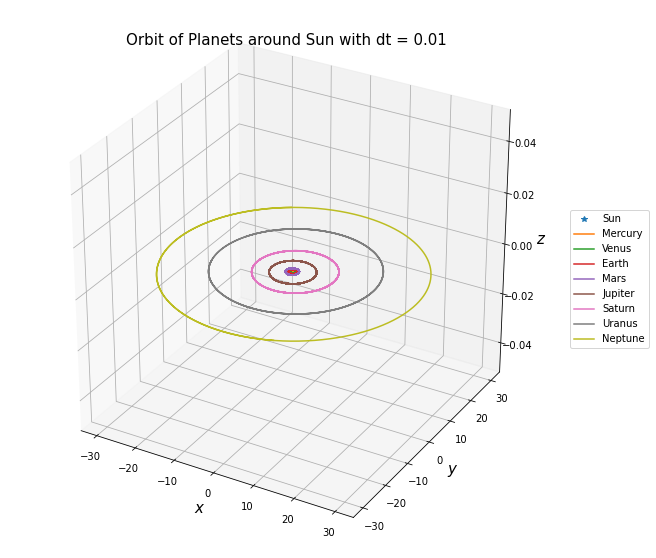

In [7]:
mercury = [np.array((0.3871, 0.2056, 7.0049, 48.3317, 77.4565, 252.2508, 1.659e-7))]
venus = [np.array((0.7233, 0.0068, 3.3947, 76.6807, 131.5330, 181.9797, 2.447e-6))]
earth = [np.array((1.0, 0.0167, 0.0001, -11.2606, 102.9472, 100.4644, 3.039e-6))]
mars = [np.array((1.5237, 0.0934, 1.8506, 49.5785, 336.0408, 355.4533, 3.226e-7))]
jupiter = [np.array((5.2034, 0.0484, 1.3053, 100.5562, 14.7539, 34.4044, 9.542e-4))]
saturn = [np.array((9.5371, 0.0542, 2.4845, 113.7150, 92.4319, 49.9443, 2.857e-4))]
uranus = [np.array((19.1913, 0.0472, 0.7699, 74.2299, 170.9642, 313.2322, 4.353e-5))]
neptune = [np.array((30.0690, 0.0086, 1.7692, 131.7217, 44.9714, 304.8800, 5.165e-5))]
planets = [mercury, venus, earth, mars, jupiter, saturn, uranus, neptune]
names = ["Mercury", "Venus", "Earth", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune"]

M_sun = 1.0
dt = 1/100
n_orbits = 1000

Positions = orbit(planet_elements = planets, M_star = M_sun, dt = dt, n_orbits = n_orbits)[0]

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = "3d")

ax.plot3D(Positions[:, 0, 0], Positions[:, 0, 1], "*", label = "Sun")

for i in range(len(planets)):
    ax.plot3D(Positions[:, i + 1, 0], Positions[:, i + 1, 1], label = f"{names[i]}")

ax.set_title(f"Orbit of Planets around Sun with dt = {dt}", fontsize = 15)
ax.set_xlabel(r"$x$", fontsize = 15)
ax.set_ylabel(r"$y$", fontsize = 15)
ax.set_zlabel(r"$z$", fontsize = 15)
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

From the 3D plot one can see that all the eight planetary orbits are stable and that the distances to the sun correspond indeed to reality. This time step is sufficient to keep a stable orbit over a long time. It can be increased, but the computation time will be much larger.

To calculate the orbits of the five innermost planets and asteroid belt of the solar system around the sun, the initial conditions for the five planets and the sun are defined as before. For the asteroids the same is done, where the number of asteroids was set to 100 and in a for loop all orbital parameters were chosen randomly for each asteroid. The orbital parameter ranges were chosen after the real values of the asteroid belt. Subsequently, the list of planets and asteroid were concatenated together into one object list. The mass of the sun, the time-step and the number of orbits, which corresponds to the orbit of the innermost planet, are also defined. The orbit function is applied to the objects list and then the resulting positions of the objects plotted for every time instance in a for loop.

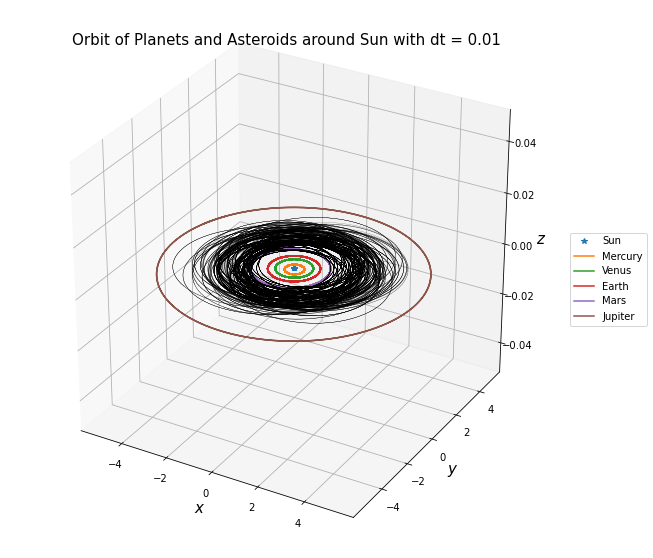

In [8]:
mercury = [np.array((0.3871, 0.2056, 7.0049, 48.3317, 77.4565, 252.2508, 1.659e-7))]
venus = [np.array((0.7233, 0.0068, 3.3947, 76.6807, 131.5330, 181.9797, 2.447e-6))]
earth = [np.array((1.0, 0.0167, 0.0001, -11.2606, 102.9472, 100.4644, 3.039e-6))]
mars = [np.array((1.5237, 0.0934, 1.8506, 49.5785, 336.0408, 355.4533, 3.226e-7))]
jupiter = [np.array((5.2034, 0.0484, 1.3053, 100.5562, 14.7539, 34.4044, 9.542e-4))]
planets = [mercury, venus, earth, mars, jupiter]
names = ["Mercury", "Venus", "Earth", "Mars", "Jupiter"]

n_asteroids = 100
asteroids = []
for i in range(n_asteroids):
    a_asteroids = np.random.uniform(2.0, 3.4)
    e_asteroids = np.random.uniform(0.0, 0.4)
    m_asteroids = np.random.uniform(1e-15, 1e-10)
    i_asteroids = np.random.uniform(0.0, 20.0)
    Omega_asteroids = np.random.uniform(0.0, 360.0)
    omega_asteroids = np.random.uniform(0.0, 360.0)
    L_asteroids = np.random.uniform(0.0, 360.0)
    asteroids.append([np.array((a_asteroids, e_asteroids, i_asteroids, Omega_asteroids, omega_asteroids, 
                                L_asteroids, m_asteroids))])
    
objects = planets + asteroids

M_sun = 1.0
dt = 1/100
n_orbits = 100

Positions = orbit(planet_elements = objects, M_star = M_sun, dt = dt, n_orbits = n_orbits)[0]

fig = plt.figure(figsize = (10, 10))
ax = plt.axes(projection = "3d")

ax.plot3D(Positions[:, 0, 0], Positions[:, 0, 1], "*", label = "Sun")

for i in range(len(planets)):
    ax.plot3D(Positions[:, i + 1, 0], Positions[:, i + 1, 1], label = f"{names[i]}")
    
for i in range(len(planets), len(objects)):
    ax.plot3D(Positions[:, i + 1, 0], Positions[:, i + 1, 1], "--", color = "k", linewidth = 0.2)
        
ax.set_title(f"Orbit of Planets and Asteroids around Sun with dt = {dt}", fontsize = 15)
ax.set_xlabel(r"$x$", fontsize = 15)
ax.set_ylabel(r"$y$", fontsize = 15)
ax.set_zlabel(r"$z$", fontsize = 15)
ax.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
plt.show()

From the 3D plot one can see that all the five planetary orbits are stable, as well as the 100 asteroid orbits between Mars and Jupiter. Also here, the distances of the objects to the sun correspond to reality. This time step is sufficient to keep a stable orbit over a long time. It can be increased, but the computation time will be much larger.